# Sea Surface Temperature Bias - NOAA OISSTv2

This notebook plots the SST bias of a model simulation vs. climataology derived from NOAA OISSTv2

%load_ext autoreload
%autoreload 2

In [1]:
import os

In [2]:
config = {
    "startyr": "1993",
    "endyr": "2017",
    "dora_id": "odiv-319",
    "pathPP": "/archive/Brandon.Reichl/fre_om5/FMS2023.01_om5_20230927/"
    + "om5_b02_minthick1em3_MLErestart/gfdl.ncrc5-intel23-prod/pp/",
}

MAR will pass for environment variables to the script when running via the web engine:

* `MAR_STARTYR`: Beginning year of analysis from model
* `MAR_ENDYR`: Ending year of analysis from model
* `MAR_DORA_ID`: The experiment ID in the database
* `MAR_PATHPP`: The top-level path to the post-processing experiment directory of the experiment

The block below will use values passed in by Dora but default to the values defined above in `config`. This is useful for interactive usage and debugging.

If executed from Dora, there will also be a `DORA_EXECUTE` variable that is set.

In [3]:
for k, v in config.items():
    config[k] = (
        os.environ[f"MAR_{k.upper()}"]
        if f"MAR_{k.upper()}" in os.environ.keys()
        else v
    )

### Import Python Modules

In [4]:
import doralite
import glob
import momlevel
import subprocess

import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

from matplotlib.colors import ListedColormap, BoundaryNorm

In [5]:
# momgrid will use a directory of pre-computed weights
import momgrid
os.environ["MOMGRID_WEIGHTS_DIR"] = "/nbhome/John.Krasting/grid_weights"

### Definie Local Parameters

In [6]:
# Define some local variables. These are taken from the doralite object
# or they can be defined locally

experiment =  doralite.dora_metadata(config["dora_id"])
pathPP = experiment["pathPP"]
expName = experiment["expName"]

# Define start and end years
start = int(config["startyr"])
end = int(config["endyr"])

### Determine What Files to Load

In [7]:
# Determine what files are needed (leave this up to the developer for flexibility)
# This is an example of what someone might do:

component = "ocean_monthly"
static = f"{component}/{component}.static.nc"
varname = "tos"

chunk = "5yr"
filelist = sorted(glob.glob(f"{pathPP}{component}/ts/**/{chunk}/{component}.*.{varname}.nc", recursive=True))

def is_in_range(file,start,end):
    start = int(start)
    end = int(end)
    target = set(list(range(start,end+1)))
    fname = os.path.basename(file)
    times = fname.split(".")[1]
    times = times.split("-")
    times = [int(x[0:4]) for x in times]
    candidate = set(list(range(times[0],times[1]+1)))
    return len(candidate.intersection(target)) > 0

filelist = [x for x in filelist if is_in_range(x,start,end)]
staticfile = f"{pathPP}/{static}"

_ = [print(x) for x in filelist]

/archive/Brandon.Reichl/fre_om5/FMS2023.01_om5_20230927/om5_b02_minthick1em3_MLErestart/gfdl.ncrc5-intel23-prod/pp/ocean_monthly/ts/monthly/5yr/ocean_monthly.199301-199712.tos.nc
/archive/Brandon.Reichl/fre_om5/FMS2023.01_om5_20230927/om5_b02_minthick1em3_MLErestart/gfdl.ncrc5-intel23-prod/pp/ocean_monthly/ts/monthly/5yr/ocean_monthly.199801-200212.tos.nc
/archive/Brandon.Reichl/fre_om5/FMS2023.01_om5_20230927/om5_b02_minthick1em3_MLErestart/gfdl.ncrc5-intel23-prod/pp/ocean_monthly/ts/monthly/5yr/ocean_monthly.200301-200712.tos.nc
/archive/Brandon.Reichl/fre_om5/FMS2023.01_om5_20230927/om5_b02_minthick1em3_MLErestart/gfdl.ncrc5-intel23-prod/pp/ocean_monthly/ts/monthly/5yr/ocean_monthly.200801-201212.tos.nc
/archive/Brandon.Reichl/fre_om5/FMS2023.01_om5_20230927/om5_b02_minthick1em3_MLErestart/gfdl.ncrc5-intel23-prod/pp/ocean_monthly/ts/monthly/5yr/ocean_monthly.201301-201712.tos.nc


### DMgetting Files

Dora cannot issue calls to dmget

In [8]:
if not "DORA_EXECUTE" in os.environ.keys():
    print("Calling dmget on files ...")
    cmd = ["dmget"]+filelist+[staticfile]
    _ = subprocess.check_output(cmd)

Calling dmget on files ...


### Load model data and grid

In [9]:
ds = momgrid.Gridset(filelist, force_symmetric=True, return_corners=True)
model_type = ds.model
ds = ds.data.sel(time=slice(f"{str(start).zfill(4)}-01-01",f"{str(end).zfill(4)}-12-31"))

In [10]:
ds

<xarray.Dataset>
Dimensions:     (time: 300, nv: 2, xh: 1440, yh: 1080, yq: 1081, xq: 1441)
Coordinates:
  * time        (time) object 1993-01-16 12:00:00 ... 2017-12-16 12:00:00
  * nv          (nv) float64 1.0 2.0
  * xh          (xh) float64 0.5 1.5 2.5 3.5 ... 1.438e+03 1.438e+03 1.44e+03
  * yh          (yh) float64 0.5 1.5 2.5 3.5 ... 1.078e+03 1.078e+03 1.08e+03
    geolon      (yh, xh) float32 -299.7 -299.5 -299.2 -299.0 ... 60.0 60.0 60.0
    geolat      (yh, xh) float32 -79.81 -79.81 -79.8 -79.8 ... 64.33 64.22 64.11
    areacello   (yh, xh) float32 3.436e+07 3.434e+07 ... 2.686e+06 1.503e+06
  * xq          (xq) float64 1.0 2.0 3.0 4.0 ... 1.439e+03 1.44e+03 1.441e+03
  * yq          (yq) float64 1.0 2.0 3.0 4.0 ... 1.079e+03 1.08e+03 1.081e+03
Data variables:
    average_DT  (time) timedelta64[ns] dask.array<chunksize=(60,), meta=np.ndarray>
    average_T1  (time) object dask.array<chunksize=(60,), meta=np.ndarray>
    average_T2  (time) object dask.array<chunksize=(60,), meta=np.ndarray>
    time_bnds   (time, nv) object dask.array<chunksize=(60, 2), meta=np.ndarray>
    tos         (time, yh, xh) float32 dask.array<chunksize=(60, 1080, 1440), meta=np.ndarray>
    geolon_c    (yq, xq) float32 -299.8 -299.6 -299.3 -299.1 ... 60.0 60.0 60.0
    geolat_c    (yq, xq) float32 -79.84 -79.84 -79.84 ... 64.28 64.17 64.06
Attributes:
    title:               om5_b02_minthick1em3_MLErestart
    associated_files:    areacello: 19930101.ocean_static.nc
    grid_type:           regular
    grid_tile:           N/A
    external_variables:  areacello

### Load observational data (if needed)

Note that Dora only mounts `/archive`, `/nbhome`, and `/home`

In [11]:
if "om4" in model_type:
    dsobs = xr.open_dataset("/archive/John.Krasting/NOAA_OISST_v2_annual_mean_1993-2017_OM4.nc", use_cftime=True)

### Define some helper function for the plots

In [12]:
def gen_levs_and_cmap(start,end,delta,cmap="RdBu_r"):
    """Generates a difference colormap centered on white"""
    boundaries = np.arange(start,end,delta)
    levels = (boundaries[0:-1] + boundaries[1:]) / 2.
    base_cmap = plt.get_cmap(cmap)
    colors = base_cmap(np.linspace(0, 1, len(levels)))
    colors[[int(len(colors) / 2) - 1]] = [1, 1, 1, 1]
    colors[[int(len(colors) / 2)]] = [1, 1, 1, 1]
    cmap = ListedColormap(colors)
    norm = BoundaryNorm(boundaries, cmap.N, clip=True)
    return (cmap, norm, boundaries)

In [13]:
def set_annotaions(ax):
    _ = ax.set_xticks([])
    _ = ax.set_yticks([])
    _ = ax.text(0.0,1.06, "SST Bias Relative to NOAA OISSTv2 (1993-2017)", weight="bold", fontsize=12, transform=ax.transAxes)
    _ = ax.text(0.0,1.02, expName, style="italic", fontsize=10, transform=ax.transAxes)
    _ = ax.text(1.0,1.05, str(starttime.values), ha="right", fontsize=8, transform=ax.transAxes)
    _ = ax.text(1.0,1.02, str(endtime.values), ha="right", fontsize=8, transform=ax.transAxes)

In [14]:
def add_stats_box(ax, stats_str, x=0.015, y=0.8):
        # Adding the text box annotation
    props = dict(
        boxstyle="round,pad=0.3", edgecolor="black", linewidth=1.5, facecolor="white"
    )
    ax.text(
        x,
        y,
        stats_str,
        transform=ax.transAxes,
        fontsize=8,
        verticalalignment="top",
        bbox=props,
    )

In [15]:
def calculate_stats(model,obs,areacello):
    diff = model - obs
    stats = {}
    stats["min"] = float(diff.min())
    stats["max"] = float(diff.max())
    stats = {**stats, **momgrid.xr_stats.xr_stats_2d(model,obs,ds.areacello,fmt="dict")}
    # Limit to 4 significant digits
    stats = {k:f"{v:.4g}" for k,v in stats.items()}
    # Stats string
    stats_str = str("\n").join([f"{k} = {v}" for k,v in stats.items()])
    return (stats, stats_str)

In [16]:
def add_colorbar(fig, cb, boundaries):
    cbar_ax = fig.add_axes([0.16, 0.06, 0.7, 0.03])
    fig.colorbar(
        cb, cax=cbar_ax, orientation="horizontal", extend="both", ticks=boundaries[::4]
    )

### Perform some calculations

In [17]:
# Time-average the model data
model = ds.tos
starttime = model.time[0]
endtime = model.time[-1]
model = momlevel.util.annual_average(model).mean("time").load()

# Obs data is already a climatology
obs = dsobs.tos

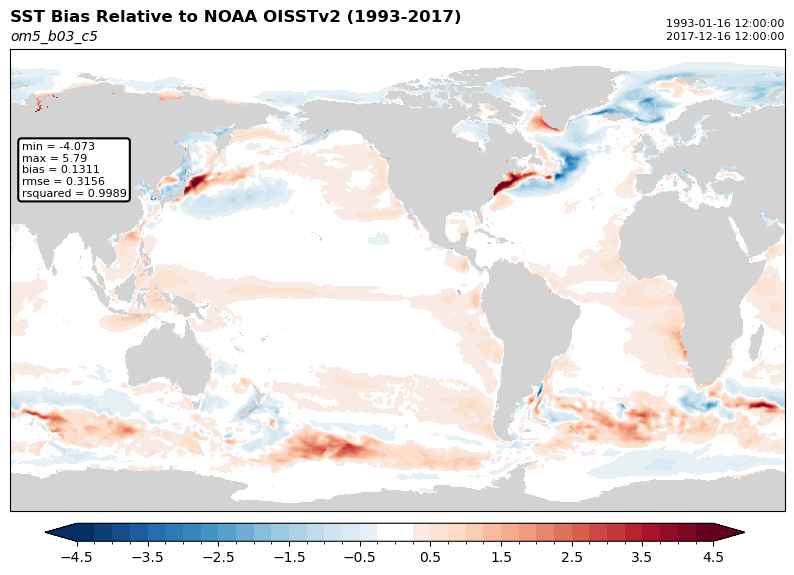

In [18]:
# Setup plot
fig = plt.figure(figsize=(10,6))
ax = plt.subplot(1,1,1, facecolor="lightgray")

# Definie geolon and geolat for plotting (use corners!)
x = ds.geolon_c
y = ds.geolat_c

# Get colormap
cmap, norm, boundaries = gen_levs_and_cmap(-4.5,4.75,0.25)

# Run pcolormesh
cb = plt.pcolormesh(x,y,model-obs, cmap=cmap, norm=norm)

# Clean up figure and add labels
set_annotaions(ax)

# Add statistics
stats, stats_str = calculate_stats(model, obs, ds.areacello)
add_stats_box(ax, stats_str)

# Add colorbar
add_colorbar(fig, cb, boundaries)